In [23]:
from modules.data_loading import load_train_data, load_test_data
from modules.data_preprocessing import clean_data, feature_engineering
import pandas as pd
import numpy as np
import ydata_profiling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report
from math import sqrt
import re
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
df=load_train_data()
df_cleaned = clean_data(df)
df_engineered = feature_engineering(df_cleaned)
df_engineered.shape[0]

1753

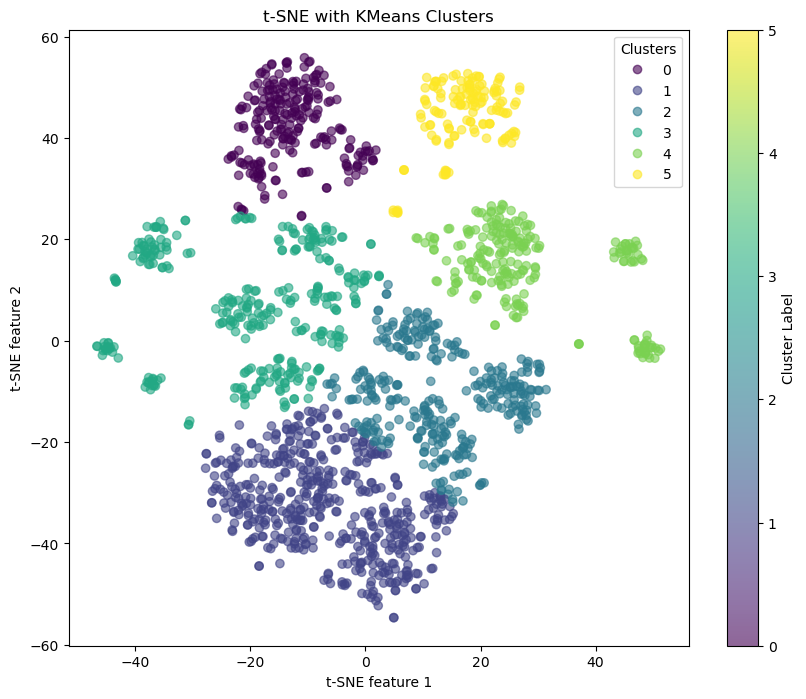

In [20]:
# Extract quantitative columns
quantitatives = df_engineered.select_dtypes(include=['int64', 'float64'])
# Drop the 'ID' column
quantitatives = quantitatives.drop(columns=['ID', 'year_built']).copy()
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler and transform the data
scaled_data = scaler.fit_transform(quantitatives)

# Create a t-SNE object
tsne = TSNE(n_components=2, random_state=0)

# Fit and transform your data
tsne_results = tsne.fit_transform(scaled_data)

# Clusters
n_clusters = 6 # 5 to start
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(tsne_results)

# Map the cluster label back to your original DataFrame
quantitatives['cluster_label'] = clusters

# Visualize
plt.figure(figsize=(10,8))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='viridis', alpha=0.6)

# Add a colorbar and legend
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Label')
legend1 = plt.legend(*scatter.legend_elements(), title="Clusters")

plt.title('t-SNE with KMeans Clusters')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.show()

In [24]:
# Prepare data for Random Forest Classifier


X = quantitatives.drop(columns=['cluster_label'])
y = quantitatives['cluster_label']

# split test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate test
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        78
           1       0.87      0.96      0.91       154
           2       0.86      0.83      0.84        94
           3       0.93      0.80      0.86        92
           4       0.89      0.86      0.87        64
           5       0.93      0.86      0.89        44

    accuracy                           0.90       526
   macro avg       0.90      0.89      0.89       526
weighted avg       0.90      0.90      0.89       526



In [25]:
# Feature importance
importances = clf.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                    Feature  Importance
11                         year_certificate    0.104262
18                               Eau chaude    0.068853
10                          has_certificate    0.067236
44                           last_year_reno    0.065356
43                                 has_reno    0.059070
30                              Climatiseur    0.052480
27                           fireplace_func    0.051607
26                            has_fireplace    0.042503
19                      Air soufflé (pulsé)    0.036050
17                              Convecteurs    0.031311
13                               near_water    0.029486
4                                build_eval    0.028024
3                                 land_eval    0.027135
8                               living_area    0.026714
5                                     rooms    0.026546
9                                 yard_area    0.026497
45                                build_age    0

<Figure size 1200x800 with 0 Axes>

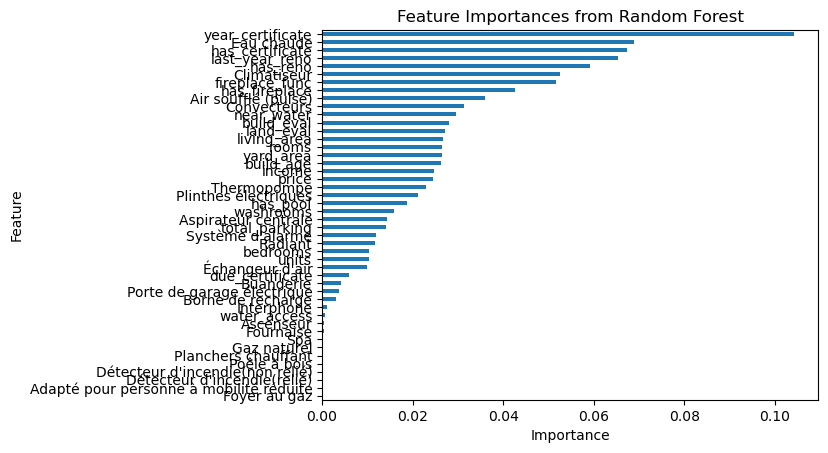

In [26]:
# Visualize
plt.figure(figsize=(12,8))
importance_df.set_index('Feature').sort_values(by='Importance').plot(kind='barh', legend=False)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

EDA Profiling

In [ ]:
profile = quantitatives.profile_report()
profile.to_file("eda_report.html")